In [ ]:
from __future__ import print_function
from keras.preprocessing.image import ImageDataGenerator
import numpy as np 
import os
import glob
import skimage.io as io
import skimage.transform as trans
import matplotlib.pyplot as plt
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import skimage.io
from skimage import color
from skimage import io
import glob
import cv2
from scipy.ndimage.interpolation import map_coordinates
from scipy.ndimage.filters import gaussian_filter
import matplotlib.pyplot as plt

In [ ]:
def elastic_transform(image, alpha, sigma, alpha_affine, random_state=None):
    """Function to do the elastic transformation
       image : The image you want to perform the elastic transformation on
       rest params are the parameters which defines the morphological operations
    """
    if random_state is None:
        random_state = np.random.RandomState(None)

    shape = image.shape
    shape_size = shape[:2]

    # Random affine
    center_square = np.float32(shape_size) // 2
    square_size = min(shape_size) // 3
    pts1 = np.float32([center_square + square_size, [center_square[0] + square_size, center_square[1] - square_size],
                       center_square - square_size])
    pts2 = pts1 + random_state.uniform(-alpha_affine, alpha_affine, size=pts1.shape).astype(np.float32)
    M = cv2.getAffineTransform(pts1, pts2)
    image = cv2.warpAffine(image, M, shape_size[::-1], borderMode=cv2.BORDER_REFLECT_101)

    dx = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma) * alpha
    dy = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma) * alpha
    dz = np.zeros_like(dx)

    x, y, z = np.meshgrid(np.arange(shape[1]), np.arange(shape[0]), np.arange(shape[2]))
    indices = np.reshape(y + dy, (-1, 1)), np.reshape(x + dx, (-1, 1)), np.reshape(z, (-1, 1))

    return map_coordinates(image, indices, order=1, mode='reflect').reshape(shape)

def draw_grid(im, grid_size):
    """ Function to draw the grid lines"""
    for i in range(0, im.shape[1], grid_size):
        cv2.line(im, (i, 0), (i, im.shape[0]), color=(1,))
    for j in range(0, im.shape[0], grid_size):
        cv2.line(im, (0, j), (im.shape[1], j), color=(1,))


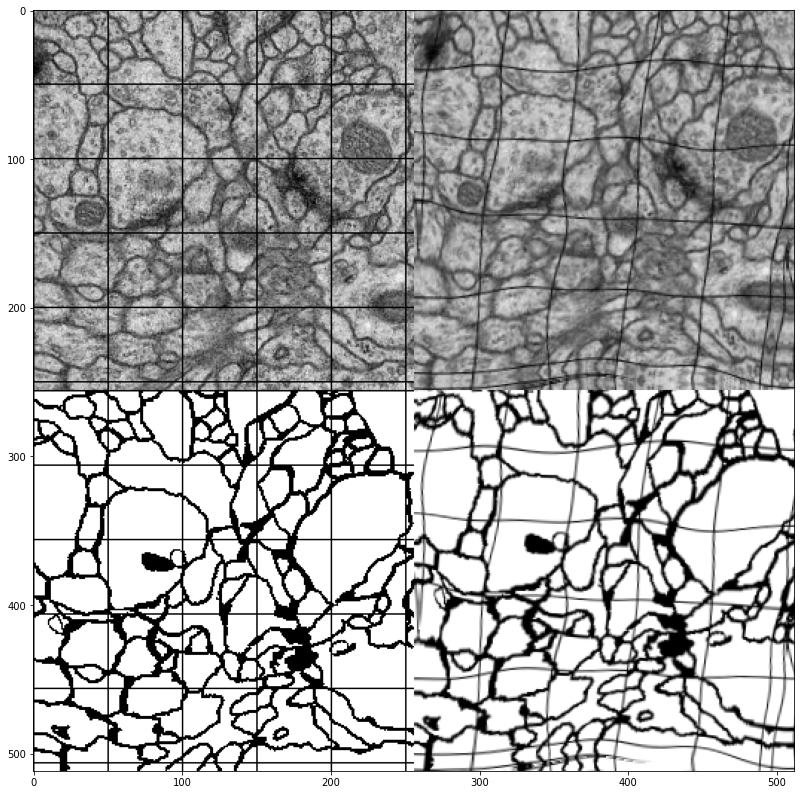

In [ ]:
im = cv2.imread('/content/unet/data/membrane/train/aug/image_0_6144147.png')  # put any image in place of the existing path to visulaize elastic deformation
im_mask = cv2.imread('/content/unet/data/membrane/train/aug/mask_0_6144147.png')

im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
im_mask = cv2.cvtColor(im_mask, cv2.COLOR_BGR2GRAY)


im_merge = np.concatenate((im[...,None], im_mask[...,None]), axis=2)
%matplotlib inline
im_merge_t = elastic_transform(im_merge, im_merge.shape[1] * 2, im_merge.shape[1] * 0.08, im_merge.shape[1] * 0.08)

# Split image and mask
im_t = im_merge_t[...,0]
im_mask_t = im_merge_t[...,1]

# Display result
plt.figure(figsize = (16,14))
plt.imshow(np.c_[np.r_[im, im_mask], np.r_[im_t, im_mask_t]], cmap='gray')


In [ ]:
def overlap_tile_processing(img_array, expend_px_width, expend_px_height):
    """
    Overlap_tile_processing mentioned in the paper
    :param img_array: input image array
    :param expend_px_width: per edge expend width ex. 512*512 => 512*(512+(92*2))
    :param expend_px_height: per edge expend height ex. 512*512 => (512+(92*2))*512
    :return: processed image array
    """
    

    def flip_horizontally(np_array):
        return cv2.flip(np_array, 1)

    def flip_vertically(np_array):
        return cv2.flip(np_array, 0)

    original_height = img_array.shape[0]
    original_width = img_array.shape[1]

    # Expanding the width first. First left and then right
    left_result = flip_horizontally(img_array[0:0 + original_height, 0:0 + expend_px_width])
    right_result = flip_horizontally(
        img_array[0:0 + original_height, original_width - expend_px_width: original_width])

    result_img = cv2.hconcat([left_result, img_array])
    result_img = cv2.hconcat([result_img, right_result])

    result_img_height = result_img.shape[0]
    result_img_width = result_img.shape[1]

    # Expand in the vertical direction
    top_result = flip_vertically(result_img[0:0 + expend_px_height, 0:0 + result_img_width])
    bottom_result = flip_vertically(
        result_img[result_img_height - expend_px_height: result_img_height, 0:0 + result_img_width])

    result_img = cv2.vconcat([top_result, result_img])
    result_img = cv2.vconcat([result_img, bottom_result])

    return result_img

In [ ]:
im_extended = overlap_tile_processing(im, 46, 46) # in the place of im, put loaded image as the input to see the extended image.

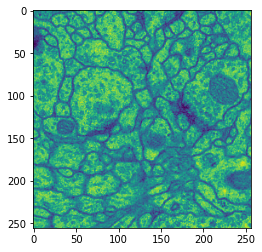

In [ ]:
plt.imshow(im)

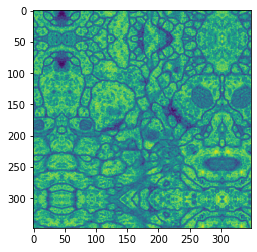

In [ ]:
plt.imshow(im_extended)

In [ ]:
def split_image2_4patch(x, y):
  """
  This function is for spliting the image into 4 patches after overlap tile processing strategy 

  """
    processing_set = zip(x, y)
    tmp_x = list()
    tmp_y = list()
    for (image, mask) in processing_set:
        tmp_x.append(image[0:572, 0:572])
        tmp_y.append(mask[0:572, 0:572])
        tmp_x.append(image[0:572, 124:696])
        tmp_y.append(mask[0:572, 124:696])
        tmp_x.append(image[124:696, 0:572])
        tmp_y.append(mask[124:696, 0:572])
        tmp_x.append(image[124:696, 124:696])
        tmp_y.append(mask[124:696, 124:696])
    return np.array(tmp_x), np.array(tmp_y)

In [ ]:
#some example weight maps plotted can be found in Training_Weight_Map.ipynb
def get_weight_matrix(y, w0, sigma):
  '''This function can be used to generate the weight maps of a single image
      params : y is the image 
      w0 = 10
      sigma is the deviation you want which is 5 in the paper'''
    labels = label(y)
    no_labels = labels == 0
    label_ids = sorted(numpy.unique(labels))[1:]

    if len(label_ids) > 1:
        distances = numpy.zeros((y.shape[0], y.shape[1], len(label_ids)))

        for i, label_id in enumerate(label_ids):
            distances[:, :, i] = distance_transform_edt(labels != label_id)

        distances = numpy.sort(distances, axis=2)
        d1 = distances[:, :, 0]
        d2 = distances[:, :, 1]
        w = w0 * numpy.exp(-1 / 2 * ((d1 + d2) / sigma) ** 2) * no_labels
    else:
        w = numpy.zeros_like(y)
    return w